# 🗂️ Análise dos Gastos Parlamentares: Explorando o Banco de Dados CEAPS
### Objetivo do Projeto:

Este projeto tem como objetivo realizar a limpeza, preparação e análise exploratória do banco de dados CEAPS (Cota para o Exercício da Atividade Parlamentar dos Senadores), que reúne todos os gastos declarados por senadores brasileiros ao longo dos anos.
Através de técnicas de Data Wrangling, visualizações com matplotlib e identificação de padrões, busca-se:

* Entender como os recursos foram utilizados por parlamentar e por tipo de despesa

* Identificar os maiores gastos por ano e suas origens

* Verificar possíveis inconsistências nos dados (valores duplicados, ausentes ou anômalos)

* Preparar os dados monetários para cálculos e análises

* Explorar tendências e comparações entre parlamentares e fornecedores

Essa análise é essencial para promover transparência, controle social e gerar insights a partir dos dados públicos.



### Importar bibliotecas e arquivos



In [472]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.signal import find_peaks

In [473]:
arquivos = glob.glob('C:/Users/laris/Downloads/dados_ceaps/*.csv')
print(f"🔎 {len(arquivos)} arquivos encontrados.")

colunas_ceaps = [
    'ano', 'numero_documento', 'nome_parlamentar', 'tipo_despesa', 
    'cnpj_cpf', 'fornecedor', 'numero_documento_fiscal', 'data_emissao', 
    'descricao', 'valor_reembolsado', 'id_documento'
]

df_lista = []

for arquivo in arquivos:
    try:
        df_temp = pd.read_csv(
            arquivo, 
            sep=';', 
            encoding='latin1', 
            skiprows=4,  # ou 0 se não tiver metadados
            names=colunas_ceaps
        )
        df_lista.append(df_temp)
        print(f"✔️ Arquivo lido com sucesso: {arquivo}")
    except Exception as e:
        print(f"❌ Erro ao ler {arquivo}: {e}")

if df_lista:
    df = pd.concat(df_lista, ignore_index=True)
    print("✅ Todos os dados foram unidos com sucesso!")

else:
    print("⚠️ Nenhum arquivo foi carregado com sucesso.")

🔎 5 arquivos encontrados.
✔️ Arquivo lido com sucesso: C:/Users/laris/Downloads/dados_ceaps\despesa_ceaps_2018.csv
✔️ Arquivo lido com sucesso: C:/Users/laris/Downloads/dados_ceaps\despesa_ceaps_2019.csv
✔️ Arquivo lido com sucesso: C:/Users/laris/Downloads/dados_ceaps\despesa_ceaps_2020.csv
✔️ Arquivo lido com sucesso: C:/Users/laris/Downloads/dados_ceaps\despesa_ceaps_2021.csv
✔️ Arquivo lido com sucesso: C:/Users/laris/Downloads/dados_ceaps\despesa_ceaps_2022.csv
✅ Todos os dados foram unidos com sucesso!


In [474]:
df.info()
df.head()
df.describe()
df.isnull().sum()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93838 entries, 0 to 93837
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ano                      93838 non-null  int64 
 1   numero_documento         93838 non-null  int64 
 2   nome_parlamentar         93838 non-null  object
 3   tipo_despesa             93838 non-null  object
 4   cnpj_cpf                 93838 non-null  object
 5   fornecedor               93838 non-null  object
 6   numero_documento_fiscal  89860 non-null  object
 7   data_emissao             93838 non-null  object
 8   descricao                57455 non-null  object
 9   valor_reembolsado        93838 non-null  object
 10  id_documento             93838 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 7.9+ MB


np.int64(0)

## 1. Pré-processamento: limpeza e estruturação dos dados

In [475]:
print(df.columns.tolist())
print(df.head())

['ano', 'numero_documento', 'nome_parlamentar', 'tipo_despesa', 'cnpj_cpf', 'fornecedor', 'numero_documento_fiscal', 'data_emissao', 'descricao', 'valor_reembolsado', 'id_documento']
    ano  numero_documento nome_parlamentar  \
0  2018                 1     ACIR GURGACZ   
1  2018                 1     ACIR GURGACZ   
2  2018                 2     ACIR GURGACZ   
3  2018                 2     ACIR GURGACZ   
4  2018                 2     ACIR GURGACZ   

                                        tipo_despesa            cnpj_cpf  \
0  Passagens aéreas, aquáticas e terrestres nacio...  63.764.211/0001-10   
1  Passagens aéreas, aquáticas e terrestres nacio...  63.764.211/0001-10   
2  Aluguel de imóveis para escritório político, c...      004.948.028-63   
3                Divulgação da atividade parlamentar  27.170.469/0001-25   
4                Divulgação da atividade parlamentar  26.320.603/0001-64   

                                 fornecedor numero_documento_fiscal  \
0  TRANSCONT

##### Identificar e tratar valores nulos

In [476]:
# Ver quantidade de nulos por coluna
print(df.isnull().sum())

# Exemplo: se quiser deletar linhas com nulos em colunas importantes
df = df.dropna(subset=['valor_reembolsado', 'data_emissao', 'nome_parlamentar'])

# Ou substituir nulos (imputar) — exemplo para valor_reembolsado zerar nulos
df['valor_reembolsado'] = df['valor_reembolsado'].fillna(0)


ano                            0
numero_documento               0
nome_parlamentar               0
tipo_despesa                   0
cnpj_cpf                       0
fornecedor                     0
numero_documento_fiscal     3978
data_emissao                   0
descricao                  36383
valor_reembolsado              0
id_documento                   0
dtype: int64


##### Identificar e remover duplicados

In [477]:
print(f"Linhas duplicadas exatas: {df.duplicated().sum()}")
df = df.drop_duplicates()

# Se quiser remover duplicados baseando-se em algumas colunas chave:
df = df.drop_duplicates(subset=['nome_parlamentar', 'data_emissao', 'valor_reembolsado', 'tipo_despesa'])


Linhas duplicadas exatas: 0


Converter datas para datetime

 Se tiver colunas com datas (ex: data ou data_documento), converta para datetime:

In [478]:
for col in ['data', 'data_documento', 'data_emissao']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)


In [479]:
df = df.drop_duplicates()

 Salvar o dataset limpo

In [480]:
df.to_csv('dados_ceaps_limpos.csv', index=False, encoding='utf-8-sig')

## 2. Análise Exploratória

In [481]:
print(df.columns.tolist())

['ano', 'numero_documento', 'nome_parlamentar', 'tipo_despesa', 'cnpj_cpf', 'fornecedor', 'numero_documento_fiscal', 'data_emissao', 'descricao', 'valor_reembolsado', 'id_documento']


 Para testar se a leitura do arquivo está correta antes de carregar vários arquivos.

In [482]:
display(df.head(10))  # mostra as 10 primeiras linhas bonitinho

,ano,numero_documento,nome_parlamentar,tipo_despesa,cnpj_cpf,fornecedor,numero_documento_fiscal,data_emissao,descricao,valor_reembolsado,id_documento
0,2018,1,ACIR GURGACZ,"Passagens aéreas, aquáticas e terrestres nacio...",63.764.211/0001-10,TRANSCONTINENTAL AGÊNCIA DE VIAGENS LTDA,SFEXYF,2018-01-02,"Companhia Aérea: LATAM, Localizador: SFEXYF. P...","1094,29",2088528
1,2018,1,ACIR GURGACZ,"Passagens aéreas, aquáticas e terrestres nacio...",63.764.211/0001-10,TRANSCONTINENTAL AGÊNCIA DE VIAGENS LTDA,V64HTR,2018-01-24,"Companhia Aérea: AZUL, Localizador: V64HTR. Pa...","1553,99",2088475
2,2018,2,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,002/18,2018-02-01,Despesa com pagamento de aluguel de imóvel par...,6000,2088477
3,2018,2,ACIR GURGACZ,Divulgação da atividade parlamentar,27.170.469/0001-25,Infiniti Comunicação,0019,2018-02-07,Despesa com divulgação da atividade parlamenta...,1000,2088478
4,2018,2,ACIR GURGACZ,Divulgação da atividade parlamentar,26.320.603/0001-64,INFORMANAHORA,00000005,2018-03-02,Despesa com divulgação da atividade parlamenta...,3000,2090387
5,2018,2,ACIR GURGACZ,Divulgação da atividade parlamentar,06.146.170/0001-65,RICCI COMUNICAÇÃO VISUAL EIRELI ME,208,2018-02-26,Despesa com divulgação da atividade parlamentar,2000,2090374
6,2018,2,ACIR GURGACZ,"Passagens aéreas, aquáticas e terrestres nacio...",63.764.211/0001-10,TRANSCONTINENTAL AGÊNCIA DE VIAGENS LTDA,ZEKZ3Y,2018-02-09,"Companhia Aérea: GOL, Localizador: ZEKZ3Y. Pas...","1063,42",2088479
7,2018,2,ACIR GURGACZ,"Passagens aéreas, aquáticas e terrestres nacio...",63.764.211/0001-10,TRANSCONTINENTAL AGÊNCIA DE VIAGENS LTDA,PZ7KUC,2018-02-15,"Companhia Aérea: AVIANCA, Localizador: PZ7KUC....","339,02",2088480
8,2018,2,ACIR GURGACZ,"Passagens aéreas, aquáticas e terrestres nacio...",63.764.211/0001-10,TRANSCONTINENTAL AGÊNCIA DE VIAGENS LTDA,AB51SM,2018-02-23,"Companhia Aérea: AZUL, Localizador: AB51SM. Pa...","1244,93",2090367
9,2018,2,ACIR GURGACZ,"Passagens aéreas, aquáticas e terrestres nacio...",63.764.211/0001-10,TRANSCONTINENTAL AGÊNCIA DE VIAGENS LTDA,PFU4HA,2018-02-25,"Companhia Aérea: AZUL, Localizador: PFU4HA. Pa...","1684,14",2090371


#### Visualização das Primeiras Linhas do Arquivo CSV para Inspeção de Metadados

In [483]:
with open(arquivos[0], encoding='latin1') as f:
    for i in range(30):
        print(f.readline())


"ULTIMA ATUALIZACAO";"06/08/2021 02:06"

"ANO";"MES";"SENADOR";"TIPO_DESPESA";"CNPJ_CPF";"FORNECEDOR";"DOCUMENTO";"DATA";"DETALHAMENTO";"VALOR_REEMBOLSADO";"COD_DOCUMENTO"

"2018";"1";"ACIR GURGACZ";"Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.";"004.948.028-63";"GILBERTO PISELO DO NASCIMENTO";"";"02/01/2018";"Despesa com pagamento de aluguel de imóvel para o escritório do Senador Acir Gurgacz";"6000";"2088462"

"2018";"1";"ACIR GURGACZ";"Passagens aéreas, aquáticas e terrestres nacionais";"63.764.211/0001-10";"TRANSCONTINENTAL AGÊNCIA DE VIAGENS LTDA";"M2CJMM";"02/01/2018";"Companhia Aérea: AVIANCA, Localizador: M2CJMM. Passageiros: ACIR MARCOS GURGACZ (Matrícula 225736, PARLAMENTAR), Voo: 6109 - NVTGRU - 31/01/2018;";"274,99";"2088476"

"2018";"1";"ACIR GURGACZ";"Passagens aéreas, aquáticas e terrestres nacionais";"63.764.211/0001-10";"TRANSCONTINENTAL AGÊNCIA DE VIAGENS LTDA";"SFEXYF";"02/01/2018";"Companhia Aérea: LATAM, Localizador: SFEX

In [484]:
df_temp = pd.read_csv(arquivos[0], sep=';', encoding='latin1', skiprows=4)
print(df_temp.columns.tolist())


['2018', '1', 'ACIR GURGACZ', 'Passagens aéreas, aquáticas e terrestres nacionais', '63.764.211/0001-10', 'TRANSCONTINENTAL AGÊNCIA DE VIAGENS LTDA', 'SFEXYF', '02/01/2018', 'Companhia Aérea: LATAM, Localizador: SFEXYF. Passageiros: ACIR MARCOS GURGACZ (Matrícula 225736, PARLAMENTAR), Voo: 3303 - NVTCGH - 15/01/2018; ACIR MARCOS GURGACZ (Matrícula 225736, PARLAMENTAR), Voo: 3594 - BSBPVH - 15/01/2018; ACIR MARCOS GURGACZ (Matrícula 225736, PARLAMENTAR), Voo: 3704 - CGHBSB - 15/01/2018;', '1094,29', '2088528']


In [485]:
df_temp.columns = df_temp.columns.str.strip().str.lower().str.replace(' ', '_')
print(df_temp.columns.tolist())


['2018', '1', 'acir_gurgacz', 'passagens_aéreas,_aquáticas_e_terrestres_nacionais', '63.764.211/0001-10', 'transcontinental_agência_de_viagens_ltda', 'sfexyf', '02/01/2018', 'companhia_aérea:_latam,_localizador:_sfexyf._passageiros:_acir_marcos_gurgacz_(matrícula_225736,_parlamentar),_voo:_3303_-_nvtcgh_-_15/01/2018;_acir_marcos_gurgacz_(matrícula_225736,_parlamentar),_voo:_3594_-_bsbpvh_-_15/01/2018;_acir_marcos_gurgacz_(matrícula_225736,_parlamentar),_voo:_3704_-_cghbsb_-_15/01/2018;', '1094,29', '2088528']


#### Leitura e verificação do cabeçalho do arquivo

In [486]:
df_temp = pd.read_csv(arquivos[0], sep=';', encoding='latin1', skiprows=4)
print(df_temp.head())
print(df_temp.columns.tolist())

   2018  1  ACIR GURGACZ Passagens aéreas, aquáticas e terrestres nacionais  \
0  2018  1  ACIR GURGACZ  Passagens aéreas, aquáticas e terrestres nacio...   
1  2018  2  ACIR GURGACZ  Aluguel de imóveis para escritório político, c...   
2  2018  2  ACIR GURGACZ                Divulgação da atividade parlamentar   
3  2018  2  ACIR GURGACZ                Divulgação da atividade parlamentar   
4  2018  2  ACIR GURGACZ                Divulgação da atividade parlamentar   

   63.764.211/0001-10  TRANSCONTINENTAL AGÊNCIA DE VIAGENS LTDA    SFEXYF  \
0  63.764.211/0001-10  TRANSCONTINENTAL AGÊNCIA DE VIAGENS LTDA    V64HTR   
1      004.948.028-63             GILBERTO PISELO DO NASCIMENTO    002/18   
2  27.170.469/0001-25                      Infiniti Comunicação      0019   
3  26.320.603/0001-64                             INFORMANAHORA  00000005   
4  06.146.170/0001-65        RICCI COMUNICAÇÃO VISUAL EIRELI ME       208   

   02/01/2018  \
0  24/01/2018   
1  01/02/2018   
2  07/02/20

## 3. Estudo do Caso - Visualizações de Gastos por Parlamentar 

Gastos dos 'TOP 10' Parlamentares

In [487]:
gastos_top10 = df.groupby('nome_parlamentar')['valor_reembolsado'].sum().sort_values(ascending=False).head(10)
print(gastos_top10)

nome_parlamentar
ROGÉRIO CARVALHO        994,35450083,8564,850159,25239,92246,71589,052...
LUIZ CARLOS DO CARMO    99,015000639,7100,735000639,6348,6360006700167...
NEY SUASSUNA            976,371259,141301,061507,923200320040004000120...
CIDINHO SANTOS          97,58157,39168,66187,18219,9970009002501601605...
IZALCI LUCAS            960826,78279,85255,42900826,78,0322,66810,1613...
CIRO NOGUEIRA           94,9470,8176,48160,392151000,35600025962396349...
RODRIGO PACHECO         937,248000188,16159,23186,84203,34172,42310,11...
DALIRIO BEBER           90038,8998,6145,161500124,8556,11495185,7254,9...
FABIANO CONTARATO       87,5986,82482535464846481051,242010023,532,251...
FERNANDO DUEIRE         824,7180,31118,64148,63200156,94450297,6611750...
Name: valor_reembolsado, dtype: object


#### Filtragem de Dados por Classificação de Gastos

In [488]:
df[df['tipo_despesa'].str.contains("divulgação", case=False)]

,ano,numero_documento,nome_parlamentar,tipo_despesa,cnpj_cpf,fornecedor,numero_documento_fiscal,data_emissao,descricao,valor_reembolsado,id_documento
3,2018,2,ACIR GURGACZ,Divulgação da atividade parlamentar,27.170.469/0001-25,Infiniti Comunicação,0019,2018-02-07,Despesa com divulgação da atividade parlamenta...,1000,2088478
4,2018,2,ACIR GURGACZ,Divulgação da atividade parlamentar,26.320.603/0001-64,INFORMANAHORA,00000005,2018-03-02,Despesa com divulgação da atividade parlamenta...,3000,2090387
5,2018,2,ACIR GURGACZ,Divulgação da atividade parlamentar,06.146.170/0001-65,RICCI COMUNICAÇÃO VISUAL EIRELI ME,208,2018-02-26,Despesa com divulgação da atividade parlamentar,2000,2090374
15,2018,3,ACIR GURGACZ,Divulgação da atividade parlamentar,26.320.603/0001-64,INFORMANAHORA,12,2018-04-11,Despesa com divulgação da atividade parlamenta...,3000,2093460
30,2018,4,ACIR GURGACZ,Divulgação da atividade parlamentar,27.170.469/0001-25,Infiniti Comunicação,21,2018-04-02,Despesa com divulgação da atividade parlamentar,500,2093446
...,...,...,...,...,...,...,...,...,...,...,...
93467,2022,12,ZENAIDE MAIA,Divulgação da atividade parlamentar,40.269.857/0001-26,Isaque de Cassio Morais Monteiro,27,2023-01-17,NaN,1000,2192812
93470,2022,12,ZENAIDE MAIA,Divulgação da atividade parlamentar,34.928.908/0001-81,Nivaldo Bernardo de Sousa - SGN,61,2023-01-23,NaN,3000,2192808
93471,2022,12,ZENAIDE MAIA,Divulgação da atividade parlamentar,05.585.247/0001-30,PN COMUNICAÇÃO INTEGRADA LTDA,1040,2022-12-06,NaN,2000,2191084
93472,2022,12,ZENAIDE MAIA,Divulgação da atividade parlamentar,08.250.946/0001-18,RÁDIO DIFUSORA DE MOSSORÓ S/A,613,2022-12-19,NaN,1500,2191866


##### Critério de filtragem para despesas superiores a R$ 5.000

In [489]:
# Converter para numérico (float), trocando vírgula por ponto e tratando erros
df['valor_reembolsado'] = df['valor_reembolsado'].astype(str).str.replace(',', '.')
df['valor_reembolsado'] = pd.to_numeric(df['valor_reembolsado'], errors='coerce')

# Agora filtre
df_filtrado = df[df['valor_reembolsado'] > 5000]
print(df_filtrado)

        ano  numero_documento  nome_parlamentar  \
2      2018                 2      ACIR GURGACZ   
11     2018                 3      ACIR GURGACZ   
14     2018                 3      ACIR GURGACZ   
28     2018                 4      ACIR GURGACZ   
33     2018                 4      ACIR GURGACZ   
...     ...               ...               ...   
93433  2022                11      ZENAIDE MAIA   
93464  2022                12      ZENAIDE MAIA   
93466  2022                12      ZENAIDE MAIA   
93532  2022                 2  ZEQUINHA MARINHO   
93823  2022                12  ZEQUINHA MARINHO   

                                            tipo_despesa            cnpj_cpf  \
2      Aluguel de imóveis para escritório político, c...      004.948.028-63   
11     Aluguel de imóveis para escritório político, c...      004.948.028-63   
14     Contratação de consultorias, assessorias, pesq...  29.817.330/0001-56   
28     Aluguel de imóveis para escritório político, c...      004.9

In [490]:
print(df['valor_reembolsado'].dtype)

float64


#### Filtragem dos registros por período anual — 2021

In [491]:
df[df['ano'] == 2021]

,ano,numero_documento,nome_parlamentar,tipo_despesa,cnpj_cpf,fornecedor,numero_documento_fiscal,data_emissao,descricao,valor_reembolsado,id_documento
60210,2021,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,001/21,2021-01-06,Despesa com aluguel de imóvel para uso do escr...,6000.00,2156383
60211,2021,1,ACIR GURGACZ,Divulgação da atividade parlamentar,26.320.603/0001-64,INFORMANAHORA,10,2021-01-25,Divulgação da atividade parlamentar,1500.00,2154509
60212,2021,1,ACIR GURGACZ,Divulgação da atividade parlamentar,13.659.201/0001-47,LINHA PURPURA FOTO E VIDEO LTDA,44,2021-01-07,Divulgação da atividade parlamentar,6000.00,2154507
60213,2021,1,ACIR GURGACZ,"Passagens aéreas, aquáticas e terrestres nacio...",17.872.428/0001-27,AMERICA VIAGENS E TURISMO LTDA - ME,VVEWKR,2021-01-21,"Companhia Aérea: LATAM, Localizador: VVEWKR. P...",1486.46,2154508
60214,2021,1,ACIR GURGACZ,"Passagens aéreas, aquáticas e terrestres nacio...",17.872.428/0001-27,AMERICA VIAGENS E TURISMO LTDA - ME,FYJJRL,2021-01-27,"Companhia Aérea: AZUL, Localizador: FYJJRL. Pa...",1890.00,2156714
...,...,...,...,...,...,...,...,...,...,...,...
77030,2021,12,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,GDAONA,2021-12-01,"Companhia Aérea: GOL, Localizador: GDAONA. Pas...",1715.45,2170983
77031,2021,12,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,JFQVZP,2021-12-15,"Companhia Aérea: LATAM, Localizador: JFQVZP. P...",2489.29,2172263
77032,2021,12,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,SSKEOB,2021-12-17,"Companhia Aérea: GOL, Localizador: SSKEOB. Pas...",1486.66,2172717
77033,2021,12,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,ZICCEX,2021-12-27,"Companhia Aérea: LATAM, Localizador: ZICCEX. P...",2515.56,2173239


#### Cálculo do total de despesas anuais

In [492]:
df.groupby('ano')['valor_reembolsado'].sum()

ano
2018    24526031.71
2019    24313066.34
2020    19103040.74
2021    23917601.50
2022    25861039.15
Name: valor_reembolsado, dtype: float64

#### Filtragem de registros por intervalo de datas específico - janeiro de 2022

In [493]:
df[(df['data_emissao'] >= '2022-01-01') & (df['data_emissao'] <= '2022-01-31')]

,ano,numero_documento,nome_parlamentar,tipo_despesa,cnpj_cpf,fornecedor,numero_documento_fiscal,data_emissao,descricao,valor_reembolsado,id_documento
60592,2021,12,ALESSANDRO VIEIRA,"Contratação de consultorias, assessorias, pesq...",23.412.247/0001-10,AMAZON AWS SERVICOS BRASIL LTDA,00665692,2022-01-03,NaN,116.25,2173827
60710,2021,12,ANGELO CORONEL,"Locomoção, hospedagem, alimentação, combustíve...",35.184.919/0001-67,JCAR Locadora de Automóveis Ltda,2,2022-01-04,Carro de apoio à atividade parlamentar.,9900.00,2172827
62689,2021,12,CID GOMES,"Aluguel de imóveis para escritório político, c...",10.967.226/0001-10,BSPAR Desenvolvimento Imobiliário LTDA,157/873054365,2022-01-04,NaN,1497.00,2172891
62690,2021,12,CID GOMES,"Aluguel de imóveis para escritório político, c...",10.967.226/0001-10,BSPAR Desenvolvimento Imobiliário LTDA,05012022,2022-01-04,NaN,3522.08,2172892
62694,2021,12,CID GOMES,Aquisição de material de consumo para uso no e...,19.093.773/0001-98,ENGAJA COMUNICAÇÃO LTDA,3161,2022-01-04,NaN,10000.00,2172896
...,...,...,...,...,...,...,...,...,...,...,...
93521,2022,1,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,IYSAJN,2022-01-07,"Companhia Aérea: GOL, Localizador: IYSAJN. Pas...",2551.82,2173622
93522,2022,1,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,SEJAPJ,2022-01-20,"Companhia Aérea: GOL, Localizador: SEJAPJ. Pas...",875.87,2174189
93523,2022,1,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,ZCJBTG,2022-01-25,"Companhia Aérea: AZUL, Localizador: ZCJBTG. Pa...",1673.86,2173624
93524,2022,1,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,IBJL7Y,2022-01-28,"Companhia Aérea: AZUL, Localizador: IBJL7Y. Pa...",1527.35,2173591


### Análise Quantitativa dos Gastos Totais por Senador
Processamento e Preparação dos Dados para Visualização Gráfica


In [494]:
# Agrupa por nome do parlamentar e soma os valores
gastos_por_senador = df.groupby('nome_parlamentar')['valor_reembolsado'].sum().sort_values(ascending=False)

# Seleciona os 10 maiores
top10 = gastos_por_senador.head(10)


#### Representação Gráfica dos Dez Maiores Valores de Gastos Reembolsados por Senador

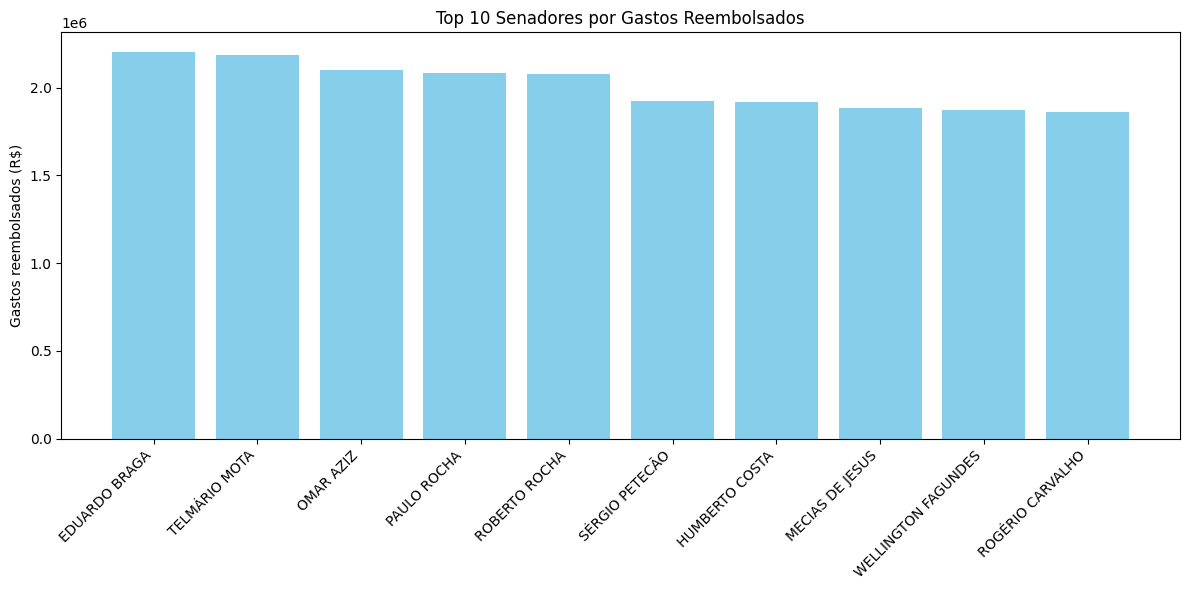

In [495]:
import matplotlib.pyplot as plt

# Configuração do gráfico
plt.figure(figsize=(12,6))  # tamanho do gráfico
plt.bar(top10.index, top10.values, color='skyblue')  # gráfico de barras
plt.xticks(rotation=45, ha='right')  # rotaciona nomes
plt.ylabel('Gastos reembolsados (R$)')
plt.title('Top 10 Senadores por Gastos Reembolsados')
plt.tight_layout()  # ajusta o layout para caber os nomes

# Exibe o gráfico
plt.show()


#### Total Consolidado de Gastos por Senador
Identificação dos Senadores com Maior Volume de Despesas Totais

In [496]:
df.groupby('nome_parlamentar')['valor_reembolsado'].sum().sort_values(ascending=False)


nome_parlamentar
EDUARDO BRAGA           2205594.70
TELMÁRIO MOTA           2187707.41
OMAR AZIZ               2098441.91
PAULO ROCHA             2082043.38
ROBERTO ROCHA           2078874.59
                           ...    
BLAIRO MAGGI               8543.95
SAMUEL ARAUJO              7710.90
SIQUEIRA CAMPOS            5926.99
VIRGINIO DE CARVALHO       5720.56
NAILDE PANTA               1650.62
Name: valor_reembolsado, Length: 171, dtype: float64

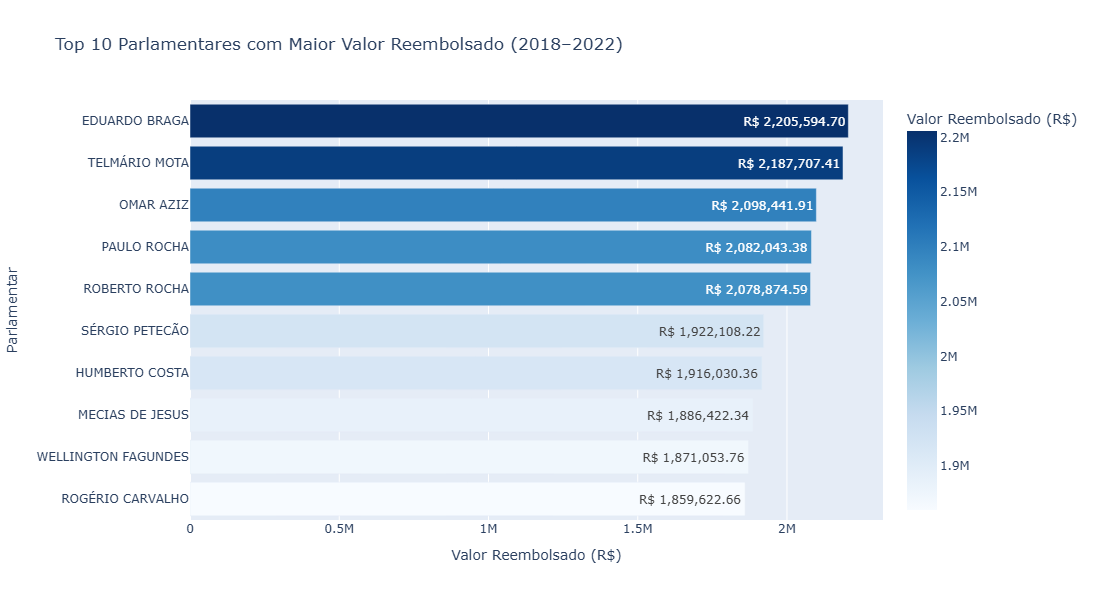

In [497]:
import plotly.express as px
import pandas as pd

# Agrupa e ordena os parlamentares pelo total gasto
gastos_por_parlamentar = df.groupby('nome_parlamentar')['valor_reembolsado'].sum().sort_values(ascending=False)
top10 = gastos_por_parlamentar.head(10).reset_index()

# Cria o gráfico interativo
fig = px.bar(
    top10,
    x='valor_reembolsado',
    y='nome_parlamentar',
    orientation='h',
    color='valor_reembolsado',
    color_continuous_scale='Blues',
    text='valor_reembolsado',
    labels={'valor_reembolsado': 'Valor Reembolsado (R$)', 'nome_parlamentar': 'Parlamentar'},
    title='Top 10 Parlamentares com Maior Valor Reembolsado (2018–2022)'
)

# Inverte o eixo Y para o maior no topo
fig.update_layout(
    yaxis=dict(autorange="reversed"),
    height=600
)

# Formata os valores como moeda brasileira no hover e na barra
fig.update_traces(texttemplate='R$ %{text:,.2f}', hovertemplate='%{y}<br>R$ %{x:,.2f}')

fig.show()


In [498]:
maior_valor = df['valor_reembolsado'].max()
print(f"O maior gasto foi de R$ {maior_valor:.2f}")


O maior gasto foi de R$ 120000.00


#### Identificação do Maior Gasto Parlamentar Declarado

In [499]:
# Encontrar a linha do maior gasto total (por valor_reembolsado)
linha_maior_gasto = df.loc[df['valor_reembolsado'].idxmax()]

# Exibir as informações principais da origem do gasto
print("Maior gasto:")
print(f"Parlamentar: {linha_maior_gasto['nome_parlamentar']}")
print(f"Ano: {linha_maior_gasto['ano']}")
print(f"Tipo de despesa: {linha_maior_gasto['tipo_despesa']}")
print(f"Fornecedor: {linha_maior_gasto['fornecedor']}")
print(f"Valor: R$ {linha_maior_gasto['valor_reembolsado']:,.2f}")
print(f"Descrição: {linha_maior_gasto['descricao']}")



Maior gasto:
Parlamentar: WELLINGTON FAGUNDES
Ano: 2020
Tipo de despesa: Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar
Fornecedor: T2 Comunicação, Video e Produções Eireli - EPP
Valor: R$ 120,000.00
Descrição: Despesa com serviço de consultoria e assessoria para o exercício do mandato parlamentar.


## Adequando Dados Monetários para Cálculos e Visualizações


Este código realiza a preparação da coluna que contém valores monetários para que o Python possa interpretá-los corretamente como números. Primeiro, ele substitui as vírgulas pelos pontos, adequando o formato decimal ao padrão aceito pela linguagem. Em seguida, converte os dados para o tipo numérico (float), permitindo a execução de operações matemáticas, como soma, ordenação e cálculos estatísticos.

Sem essa transformação, os valores seriam tratados como texto, o que impossibilita realizar cálculos ou análises quantitativas sobre os dados.



In [500]:
df['valor_reembolsado'] = df['valor_reembolsado'].astype(str).str.replace(',', '.')
df['valor_reembolsado'] = pd.to_numeric(df['valor_reembolsado'], errors='coerce')


In [501]:
print(df['valor_reembolsado'].head())
print(df['valor_reembolsado'].dtype)


0    1094.29
1    1553.99
2    6000.00
3    1000.00
4    3000.00
Name: valor_reembolsado, dtype: float64
float64


### Consulta de despesas agregadas por exercício anual

esta etapa, foi realizada uma agregação dos dados de reembolso por parlamentar, ano a ano. A análise identificou, para cada ano entre 2018 e 2022, o parlamentar com o maior valor acumulado de reembolso registrado no sistema.

Esse tipo de agrupamento permite observar padrões de comportamento individual, possíveis excessos, ou simplesmente o uso mais frequente da cota parlamentar por determinados senadores.

A lógica aplicada consistiu em:

- Agrupar os dados por `ano` e `nome_parlamentar`;
- Somar os valores reembolsados por cada parlamentar em cada ano;
- Selecionar o parlamentar com o maior valor total por ano;
- Apresentar o resultado final ordenado cronologicamente.

A análise é útil para detectar **anomalias temporais** e **eventos atípicos** em valores individuais de reembolso.

In [502]:
col_ano = 'ano'
col_valor = 'valor_reembolsado'
col_desc = 'tipo_despesa'

idx_maior_por_ano = df.groupby(col_ano)[col_valor].idxmax()
maiores_gastos_ano = df.loc[idx_maior_por_ano, [col_ano, col_valor, col_desc]]
print(maiores_gastos_ano)


        ano  valor_reembolsado  \
21223  2018           103900.0   
42249  2019            79200.0   
59382  2020           120000.0   
74543  2021            65000.0   
91662  2022            77012.0   

                                            tipo_despesa  
21223                Divulgação da atividade parlamentar  
42249  Contratação de consultorias, assessorias, pesq...  
59382  Contratação de consultorias, assessorias, pesq...  
74543  Contratação de consultorias, assessorias, pesq...  
91662  Contratação de consultorias, assessorias, pesq...  


In [503]:
# Agrupa por ano e parlamentar, somando os gastos
gastos_por_parlamentar = df.groupby(['ano', 'nome_parlamentar'])['valor_reembolsado'].sum().reset_index()

# Para cada ano, seleciona o parlamentar com maior gasto
idx_maior_por_ano = gastos_por_parlamentar.groupby('ano')['valor_reembolsado'].idxmax()

# Cria uma nova tabela com os parlamentares que mais gastaram por ano
parlamentares_top = gastos_por_parlamentar.loc[idx_maior_por_ano].sort_values(by='ano')
print(parlamentares_top)


      ano nome_parlamentar  valor_reembolsado
19   2018    EDUARDO BRAGA          527524.18
173  2019        OMAR AZIZ          525285.22
295  2020    TELMÁRIO MOTA          485131.59
361  2021        OMAR AZIZ          524609.88
438  2022    LUCAS BARRETO          503319.78


A seguir, identificamos o parlamentar com o maior volume de reembolsos totais em cada ano do período analisado.

A análise foi feita com base no agrupamento por `ano` e `nome_parlamentar`, utilizando a soma dos valores reembolsados. Para cada ano, selecionamos o parlamentar com o maior total acumulado.

Essa informação pode ser útil para análises comparativas, estudos de padrões de gastos e identificação de possíveis anomalias ou recorrências.

In [504]:
# Pegar o maior gasto por parlamentar em cada ano
maior_por_ano = df.groupby(['ano', 'nome_parlamentar'])['valor_reembolsado'].sum().reset_index()

# Pega apenas o parlamentar com maior gasto em cada ano
idx_max = maior_por_ano.groupby('ano')['valor_reembolsado'].idxmax()
maior_por_ano_top = maior_por_ano.loc[idx_max]



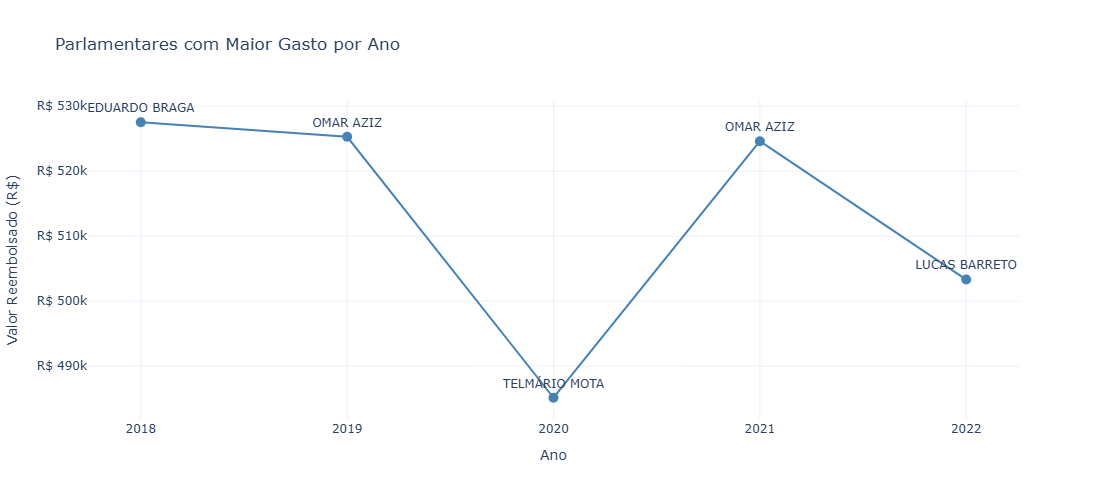

In [505]:
import plotly.graph_objects as go

# Organizar os dados
anos = maior_por_ano_top['ano'].astype(str)
nomes = maior_por_ano_top['nome_parlamentar']
valores = maior_por_ano_top['valor_reembolsado']

# Criar o gráfico interativo
fig = go.Figure()

# Adiciona a linha principal
fig.add_trace(go.Scatter(
    x=anos,
    y=valores,
    mode='lines+markers+text',
    text=nomes,
    textposition='top center',
    marker=dict(size=10, color='steelblue'),
    line=dict(color='steelblue'),
    name='Gastos'
))

# Título e rótulos
fig.update_layout(
    title='Parlamentares com Maior Gasto por Ano',
    xaxis_title='Ano',
    yaxis_title='Valor Reembolsado (R$)',
    template='plotly_white',
    height=500,
)

# Formatação do eixo Y como moeda
fig.update_yaxes(tickprefix="R$ ")

# Exibir o gráfico
fig.show()


In [506]:
col_ano = 'ano'
col_valor = 'valor_reembolsado'
col_desc = 'tipo_despesa'

# Garante que está em float
df[col_valor] = df[col_valor].astype(float)

# Pega os maiores gastos por ano
idx_maior_por_ano = df.groupby(col_ano)[col_valor].idxmax()
maiores_gastos_ano = df.loc[idx_maior_por_ano, [col_ano, 'nome_parlamentar', col_valor, col_desc]]

print(maiores_gastos_ano)


        ano     nome_parlamentar  valor_reembolsado  \
21223  2018      ROSE DE FREITAS           103900.0   
42249  2019      ROSE DE FREITAS            79200.0   
59382  2020  WELLINGTON FAGUNDES           120000.0   
74543  2021       SÉRGIO PETECÃO            65000.0   
91662  2022       SÉRGIO PETECÃO            77012.0   

                                            tipo_despesa  
21223                Divulgação da atividade parlamentar  
42249  Contratação de consultorias, assessorias, pesq...  
59382  Contratação de consultorias, assessorias, pesq...  
74543  Contratação de consultorias, assessorias, pesq...  
91662  Contratação de consultorias, assessorias, pesq...  


In [507]:
# Aplica um estilo com barras de cor no valor
maiores_gastos_ano.style\
    .format({'valor_reembolsado': 'R${:,.2f}'})\
    .bar(subset='valor_reembolsado', color='#90CAF9')\
    .set_caption("Maior gasto do Senado por ano")


,ano,nome_parlamentar,valor_reembolsado,tipo_despesa
21223,2018,ROSE DE FREITAS,"R$103,900.00",Divulgação da atividade parlamentar
42249,2019,ROSE DE FREITAS,"R$79,200.00","Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar"
59382,2020,WELLINGTON FAGUNDES,"R$120,000.00","Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar"
74543,2021,SÉRGIO PETECÃO,"R$65,000.00","Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar"
91662,2022,SÉRGIO PETECÃO,"R$77,012.00","Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar"


### Visualização Estatística dos Valores Reembolsados com Ênfase na Detecção de Outliers

O boxplot abaixo representa a distribuição dos valores reembolsados por senadores entre 2018 e 2022.

Essa visualização permite identificar outliers — valores atípicos que estão significativamente acima da média — por meio de pontos fora dos limites da caixa.

É possível observar uma grande assimetria nos dados, com a presença de diversos valores elevados, indicando que **alguns reembolsos estão muito acima da média geral**, o que pode indicar anomalias, excessos ou casos a serem analisados individualmente.



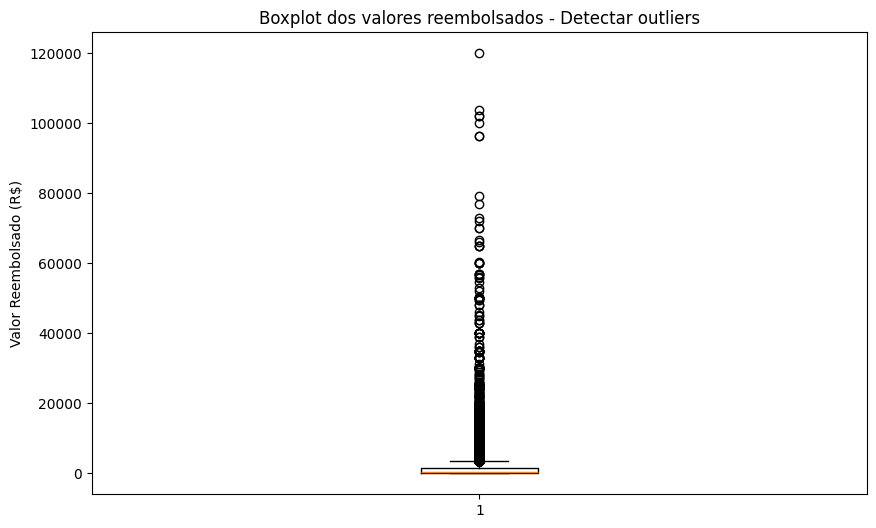

In [508]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.boxplot(df['valor_reembolsado'])
plt.title('Boxplot dos valores reembolsados - Detectar outliers')
plt.ylabel('Valor Reembolsado (R$)')
plt.show()

#### Análise Temporal dos Gastos com Destaque para Períodos Eleitorais

Neste gráfico, realizamos uma análise temporal dos gastos mensais reembolsados pelos senadores, entre os anos de 2018 a 2022, com o objetivo de identificar comportamentos sazonais e padrões de aumento de despesas em períodos estratégicos, como eleições.

O processo consistiu em:

* Agrupamento dos dados por mês (ano_mes), somando o valor total reembolsado em cada período;

* Criação de uma série temporal, plotando a evolução dos gastos ao longo dos meses;

* Inserção de linhas verticais em setembro e outubro dos anos eleitorais (2018, 2020 e 2022), destacando graficamente os meses em que ocorreram campanhas políticas.


As linhas vermelhas tracejadas indicam os meses que antecedem ou correspondem ao período eleitoral, possibilitando a comparação visual entre os picos de gasto e os eventos políticos.

Essa visualização facilita a identificação de possíveis correlações entre aumentos de despesa e contextos eleitorais, sendo uma importante ferramenta de transparência e prestação de contas públicas.




### Consulta e Análise dos Maiores Gastos com Viagens Parlamentares

In [509]:
# Filtrar apenas os registros de viagens
df_viagens = df[df['tipo_despesa'].str.contains('passagens', case=False, na=False)]

In [510]:
total_viagens = df_viagens['valor_reembolsado'].sum()
print(f'Total gasto com viagens: R$ {total_viagens:,.2f}')

Total gasto com viagens: R$ 28,110,058.60


#### Ranking de Gastos em Viagens por Parlamentar — Análise de Dados

In [511]:
gastos_por_parlamentar = df_viagens.groupby('nome_parlamentar')['valor_reembolsado'].sum().sort_values(ascending=False)
print(gastos_por_parlamentar.head(10))

nome_parlamentar
RANDOLFE RODRIGUES         795418.87
PAULO ROCHA                712073.27
ROMÁRIO                    694914.29
OMAR AZIZ                  684141.91
FERNANDO BEZERRA COELHO    642885.74
ZEQUINHA MARINHO           613183.94
ALESSANDRO VIEIRA          610005.80
WEVERTON ROCHA             572739.78
VENEZIANO VITAL DO RÊGO    527204.83
LUIS CARLOS HEINZE         508264.79
Name: valor_reembolsado, dtype: float64


##### Fornecedores mais utilizados

In [512]:
gastos_por_fornecedor = df_viagens.groupby('fornecedor')['valor_reembolsado'].sum().sort_values(ascending=False)
print(gastos_por_fornecedor.head(10))


fornecedor
LATAM                              3542116.81
ADRIA VIAGENS E TURISMO LTDA       2432206.72
GOL                                1964178.16
Adria Viagens e Turismo Ltda       1140771.10
Adria Viagens e Turismo LTDA        737966.69
AZUL                                724957.28
ADRIA VIAGENS E TURISMO             681738.89
Adria Viagens e Turismo LTDA ME     678471.20
LM TURISMO                          645800.59
Exceller Tour                       588771.41
Name: valor_reembolsado, dtype: float64


##### Os Senadores que mais tiveram gastos com viagens em todo o periodo

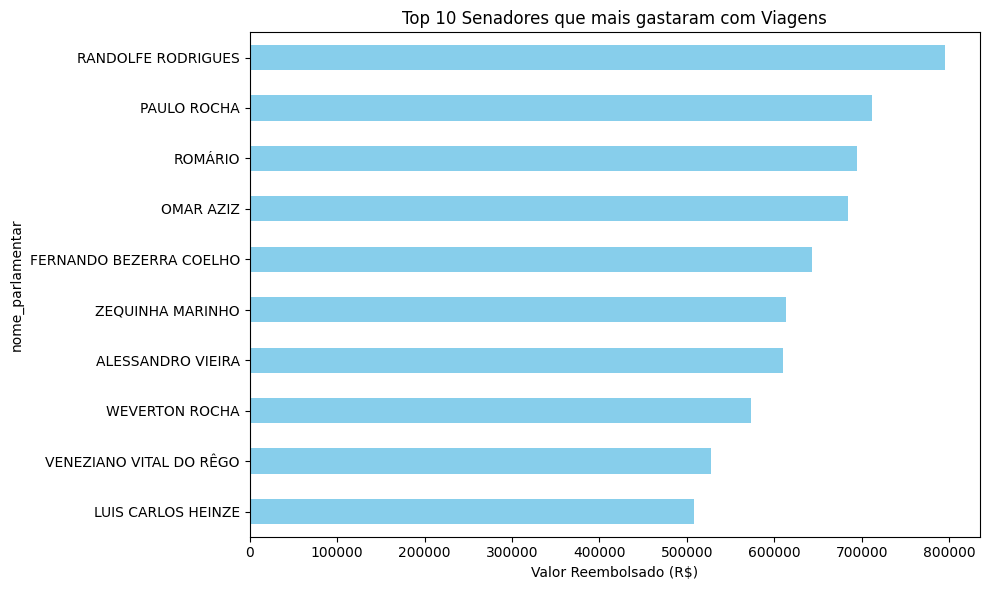

In [513]:
import matplotlib.pyplot as plt

# Top 10 senadores que mais gastaram com viagens
top10 = gastos_por_parlamentar.head(10)

plt.figure(figsize=(10, 6))
top10.plot(kind='barh', color='skyblue')
plt.title('Top 10 Senadores que mais gastaram com Viagens')
plt.xlabel('Valor Reembolsado (R$)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Análise das Variações Anuais nos Gastos

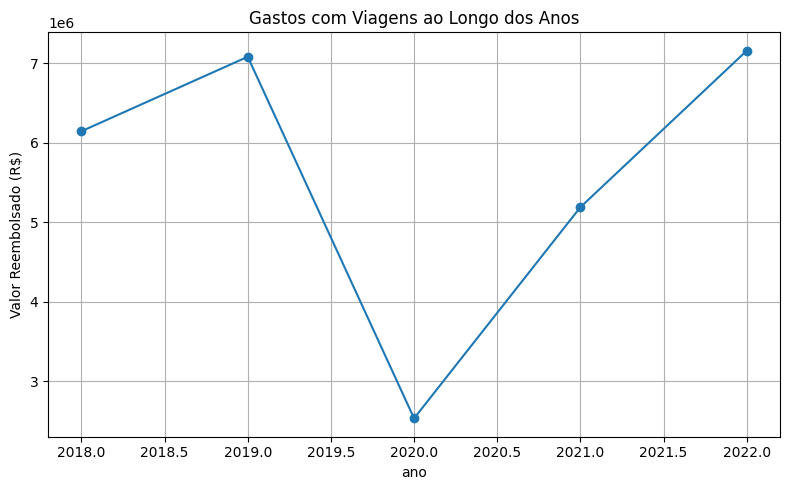

In [514]:
gastos_por_ano = df_viagens.groupby('ano')['valor_reembolsado'].sum()

plt.figure(figsize=(8, 5))
gastos_por_ano.plot(marker='o')
plt.title('Gastos com Viagens ao Longo dos Anos')
plt.ylabel('Valor Reembolsado (R$)')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Análise da Distribuição dos Gastos com Passagens Aéreas

Visualização dos dados por meio de Boxplot para detecção de outliers

In [515]:
df_viagens = df[df['tipo_despesa'].str.contains('passagens', case=False, na=False)]

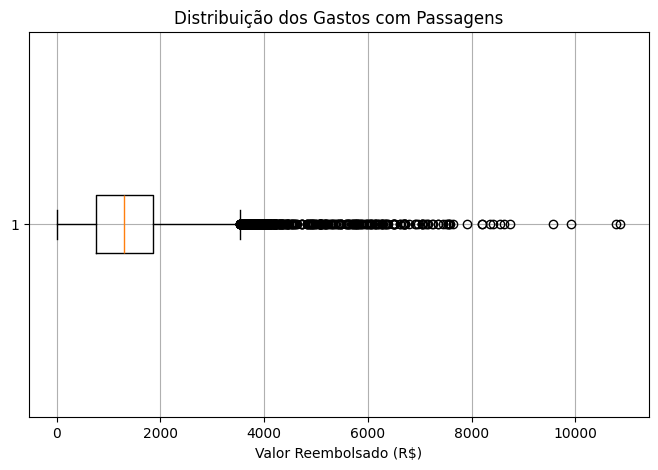

In [516]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.boxplot(df_viagens['valor_reembolsado'].dropna(), vert=False)
plt.title('Distribuição dos Gastos com Passagens')
plt.xlabel('Valor Reembolsado (R$)')
plt.grid(True)
plt.show()


##### Detecção Matemática de Outliers Utilizando o Método do Intervalo Interquartil (IQR)

In [517]:
# Cálculo do IQR (Intervalo Interquartílico)
q1 = df_viagens['valor_reembolsado'].quantile(0.25)
q3 = df_viagens['valor_reembolsado'].quantile(0.75)
iqr = q3 - q1

# Definindo limites para outliers
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

# Filtrando os outliers
outliers = df_viagens[df_viagens['valor_reembolsado'] > limite_superior]

print(f"Número de possíveis gastos exagerados: {len(outliers)}")
display(outliers[['nome_parlamentar', 'valor_reembolsado', 'tipo_despesa', 'fornecedor', 'descricao']].sort_values(by='valor_reembolsado', ascending=False).head(10))


Número de possíveis gastos exagerados: 533


,nome_parlamentar,valor_reembolsado,tipo_despesa,fornecedor,descricao
89268,OMAR AZIZ,10871.78,"Passagens aéreas, aquáticas e terrestres nacio...",GOL,"Companhia Aérea: GOL, Localizador: RLOSVA. Pas..."
87245,LUIS CARLOS HEINZE,10783.86,"Passagens aéreas, aquáticas e terrestres nacio...",LM TURISMO,"Companhia Aérea: LATAM, Localizador: ZDVTAP. P..."
87543,MAILZA GOMES,9924.36,"Passagens aéreas, aquáticas e terrestres nacio...",GOL,"Companhia Aérea: GOL, Localizador: QBBVME. Pas..."
20283,ROMERO JUCÁ,9579.92,"Passagens aéreas, aquáticas e terrestres nacio...",LM EMPRESA DE TURISMO LTDA,"Companhia Aérea: LATAM, Localizador: BQSYMQ. P..."
77275,ALESSANDRO VIEIRA,8750.19,"Passagens aéreas, aquáticas e terrestres nacio...",MM TOUR,"Companhia Aérea: LATAM, Localizador: KPLZIT. P..."
83042,FLÁVIO BOLSONARO,8629.76,"Passagens aéreas, aquáticas e terrestres nacio...",TAM,"Companhia Aérea: TAM, Localizador: VBTOJC. Pas..."
71930,OMAR AZIZ,8543.38,"Passagens aéreas, aquáticas e terrestres nacio...",LATAM,"Companhia Aérea: LATAM, Localizador: ARWVPF. P..."
71914,OMAR AZIZ,8406.38,"Passagens aéreas, aquáticas e terrestres nacio...",LATAM,"Companhia Aérea: LATAM, Localizador: SXBGUR. P..."
77301,ALESSANDRO VIEIRA,8350.51,"Passagens aéreas, aquáticas e terrestres nacio...",MM TOUR,"Companhia Aérea: TAM, Localizador: JBAPBM. Pas..."
71928,OMAR AZIZ,8207.74,"Passagens aéreas, aquáticas e terrestres nacio...",LATAM,"Companhia Aérea: LATAM, Localizador: DPAPWD. P..."


In [518]:
maiores_gastos = df_viagens.sort_values(by='valor_reembolsado', ascending=False).head(20)
display(maiores_gastos[['nome_parlamentar', 'valor_reembolsado', 'fornecedor', 'descricao']])

,nome_parlamentar,valor_reembolsado,fornecedor,descricao
89268,OMAR AZIZ,10871.78,GOL,"Companhia Aérea: GOL, Localizador: RLOSVA. Pas..."
87245,LUIS CARLOS HEINZE,10783.86,LM TURISMO,"Companhia Aérea: LATAM, Localizador: ZDVTAP. P..."
87543,MAILZA GOMES,9924.36,GOL,"Companhia Aérea: GOL, Localizador: QBBVME. Pas..."
20283,ROMERO JUCÁ,9579.92,LM EMPRESA DE TURISMO LTDA,"Companhia Aérea: LATAM, Localizador: BQSYMQ. P..."
77275,ALESSANDRO VIEIRA,8750.19,MM TOUR,"Companhia Aérea: LATAM, Localizador: KPLZIT. P..."
83042,FLÁVIO BOLSONARO,8629.76,TAM,"Companhia Aérea: TAM, Localizador: VBTOJC. Pas..."
71930,OMAR AZIZ,8543.38,LATAM,"Companhia Aérea: LATAM, Localizador: ARWVPF. P..."
71914,OMAR AZIZ,8406.38,LATAM,"Companhia Aérea: LATAM, Localizador: SXBGUR. P..."
77301,ALESSANDRO VIEIRA,8350.51,MM TOUR,"Companhia Aérea: TAM, Localizador: JBAPBM. Pas..."
71928,OMAR AZIZ,8207.74,LATAM,"Companhia Aérea: LATAM, Localizador: DPAPWD. P..."


In [519]:
# Mostra a linha 89268
linha = df.loc[89268]
print(linha['descricao'])


Companhia Aérea: GOL, Localizador: RLOSVA. Passageiros: OMAR JOSÉ ABDEL AZIZ (Matrícula 296500, PARLAMENTAR), Voo: 1727 - MANAUS - BRASÍLIA - 11/04/2022; MARCELO CARNEIRO GARCIA (Matrícula 304016, COMISSIONADO), Voo: 1727 - MANAUS - BRASÍLIA - 11/04/2022; OMAR JOSÉ ABDEL AZIZ (Matrícula 296500, PARLAMENTAR), Voo: 1726 - BRASÍLIA - MANAUS - 12/04/2022; MARCELO CARNEIRO GARCIA (Matrícula 304016, COMISSIONADO), Voo: 1726 - BRASÍLIA - MANAUS - 12/04/2022;


In [520]:
# Mostra a linha 20283
linha = df.loc[87245]
print(linha['descricao'])

Companhia Aérea: LATAM, Localizador: ZDVTAP. Passageiros: CLAUDIO PEREIRA SANTA CATARINA (Matrícula 340902, COMISSIONADO), Voo: 3764 - BRASÍLIA / PORTO ALEGRE - 18/07/2022; NIEGE SIQUEIRA DAS NEVES (Matrícula 388339, COMISSIONADO), Voo: 3764 - BRASÍLIA / PORTO ALEGRE - 18/07/2022; RAFAEL CAMARGO DA SILVA (Matrícula 341931, COMISSIONADO), Voo: 3764 - BRASÍLIA / PORTO ALEGRE - 18/07/2022; NIEGE SIQUEIRA DAS NEVES (Matrícula 388339, COMISSIONADO), Voo: 3767 - PORTO ALEGRE / BRASÍLIA - 21/07/2022; RAFAEL CAMARGO DA SILVA (Matrícula 341931, COMISSIONADO), Voo: 3767 - PORTO ALEGRE / BRASÍLIA - 21/07/2022; CLAUDIO PEREIRA SANTA CATARINA (Matrícula 340902, COMISSIONADO), Voo: 3767 - PORTO ALEGRE / BRASÍLIA - 21/07/2022;


#### Tratamento dos Dados: Conversão de Datas e Seleção de Despesas Relacionadas a Viagens

In [521]:
# Converter data_emissao para datetime
df['data_emissao'] = pd.to_datetime(df['data_emissao'], dayfirst=True, errors='coerce')

# Filtrar gastos de viagens - ajusta conforme categorias reais do seu df
viagens = df[df['tipo_despesa'].str.contains('passagem|transporte|hospedagem', case=False, na=False)]


#### Análise Mensal da Concentração dos Gastos com Viagens

Extração do mês a partir da coluna data_emissao

Agrupamento mensal dos registros com soma acumulada dos gastos

In [522]:
viagens = df[df['tipo_despesa'].str.contains('passagem|transporte|hospedagem', case=False, na=False)].copy()
viagens['mes'] = viagens['data_emissao'].dt.month


Plotar gráfico de barras dos gastos por mês para visualizar a concentração:


### Análise Temporal de Anomalias nos Gastos Relacionadas a Eventos Sazonais e Campanhas Eleitorais
Detecção de picos estatisticamente relevantes nos dados mensais de gastos

Inserção manual de anotações temporais correspondentes aos períodos eleitorais para análise comparativa

Implementação de marcadores verticais em séries temporais para demarcar intervalos de campanhas eleitorais em visualizações gráficas

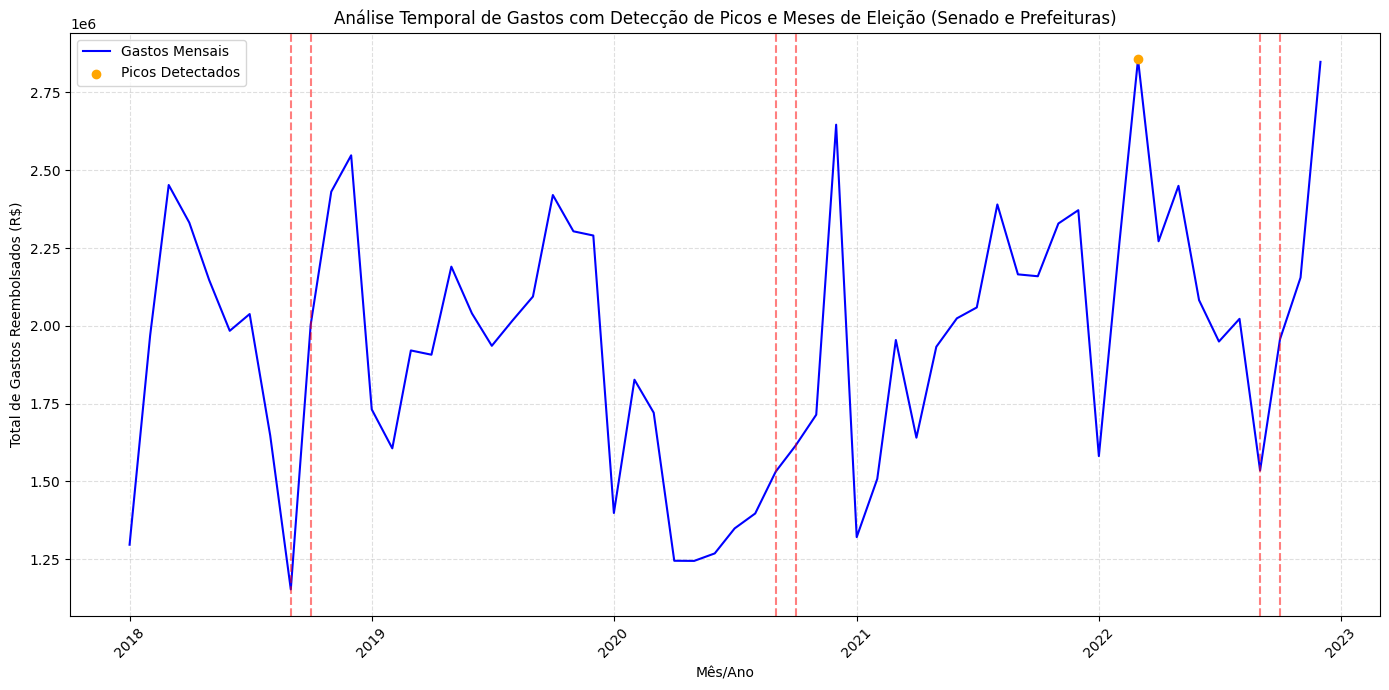

In [523]:
# Garantir datetime
df['data_emissao'] = pd.to_datetime(df['data_emissao'], errors='coerce')

# Agrupar por ano/mês
df['ano_mes'] = df['data_emissao'].dt.to_period('M').dt.to_timestamp()
gastos_mensais = df.groupby('ano_mes')['valor_reembolsado'].sum().sort_index()

# Filtrar intervalo de interesse
inicio = pd.Timestamp('2018-01-01')
fim = pd.Timestamp('2022-12-31')
gastos_mensais = gastos_mensais[(gastos_mensais.index >= inicio) & (gastos_mensais.index <= fim)]

# Detectar picos estatísticos
picos, _ = find_peaks(gastos_mensais.values, height=gastos_mensais.mean() + 2*gastos_mensais.std())

#  Datas de eleição (Senado e Prefeituras)
datas_eleitorais = [
    '2018-09', '2018-10',
    '2020-09', '2020-10',
    '2022-09', '2022-10'
]
datas_eleitorais = [pd.Timestamp(data) for data in datas_eleitorais]

# Gráfico
plt.figure(figsize=(14,7))
plt.plot(gastos_mensais.index, gastos_mensais.values, label='Gastos Mensais', color='blue')

# Marcar picos
plt.scatter(gastos_mensais.index[picos], gastos_mensais.values[picos], color='orange', label='Picos Detectados', zorder=5)

# Linhas verticais apenas nos meses eleitorais
for data in gastos_mensais.index:
    if data in datas_eleitorais:
        plt.axvline(x=data, color='red', linestyle='--', alpha=0.5)

plt.title('Análise Temporal de Gastos com Detecção de Picos e Meses de Eleição (Senado e Prefeituras)')
plt.xlabel('Mês/Ano')
plt.ylabel('Total de Gastos Reembolsados (R$)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###  Cálculo da Proporção Relativa dos Gastos com Viagens Sobre o Total de Despesas Agregadas por Parlamentar
Agregação dos valores totais de despesas por parlamentar (SUM)

Agregação dos valores totais de despesas categorizadas como viagens por parlamentar (SUM com filtro)

Computação da razão percentual entre despesas de viagens e despesas totais por parlamentar (Operação aritmética: divisão e multiplicação por 100)

In [524]:
total_por_parlamentar = df.groupby('nome_parlamentar')['valor_reembolsado'].sum()
viagens_por_parlamentar = viagens.groupby('nome_parlamentar')['valor_reembolsado'].sum()

proporcao_viagens = (viagens_por_parlamentar / total_por_parlamentar).fillna(0).sort_values(ascending=False)

print(proporcao_viagens.head(10))


nome_parlamentar
IONE GUIMARÃES      0.835789
CIRO NOGUEIRA       0.813436
ELIANE NOGUEIRA     0.704298
OGARI PACHECO       0.692379
GIORDANO            0.665920
ZÉ SANTANA          0.601399
VICENTINHO ALVES    0.517332
GLADSON CAMELI      0.501987
RUDSON LEITE        0.491833
TELMÁRIO MOTA       0.461600
Name: valor_reembolsado, dtype: float64


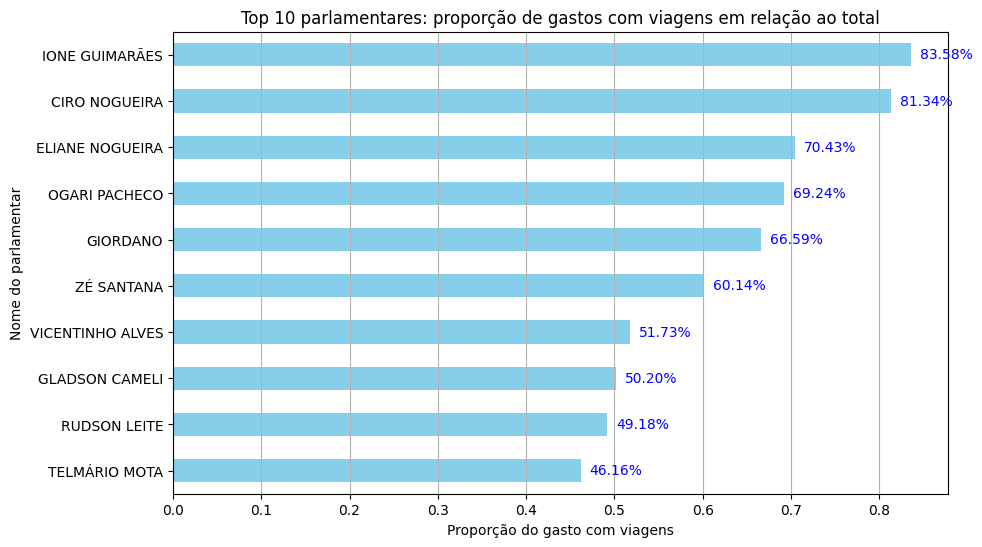

In [525]:
# Supondo que você já tenha o top10, que é uma Series com nomes e proporções
top10 = proporcao_viagens.head(10)

plt.figure(figsize=(10,6))

# Gráfico de barras horizontais
ax = top10.plot(kind='barh', color='skyblue')

# Título e labels
plt.title('Top 10 parlamentares: proporção de gastos com viagens em relação ao total')
plt.xlabel('Proporção do gasto com viagens')
plt.ylabel('Nome do parlamentar')

# Mostrar valores % no final de cada barra
for i, valor in enumerate(top10):
    ax.text(valor + 0.01, i, f"{valor:.2%}", color='blue', va='center')

# Inverter eixo y para maior ficar em cima
plt.gca().invert_yaxis()

plt.grid(axis='x')  # Linhas horizontais para facilitar leitura

plt.show()


#### Determinação dos Parlamentares com Maior Volume de Gastos por Ano

In [526]:
# Agrupa por ano e nome do parlamentar somando os gastos
gastos_por_ano_parlamentar = df.groupby(['ano', 'nome_parlamentar'])['valor_reembolsado'].sum()

# Para cada ano, pega o parlamentar com maior gasto
maiores_gastos_por_ano = gastos_por_ano_parlamentar.groupby(level=0).idxmax().apply(lambda x: (x[0], x[1]))

# Agora, extrai as informações para montar uma tabela
resultado = []

for ano, nome in maiores_gastos_por_ano:
    valor = gastos_por_ano_parlamentar.loc[(ano, nome)]
    resultado.append({'ano': ano, 'nome_parlamentar': nome, 'valor_reembolsado': valor})

df_maiores = pd.DataFrame(resultado)

print(df_maiores)


    ano nome_parlamentar  valor_reembolsado
0  2018    EDUARDO BRAGA          527524.18
1  2019        OMAR AZIZ          525285.22
2  2020    TELMÁRIO MOTA          485131.59
3  2021        OMAR AZIZ          524609.88
4  2022    LUCAS BARRETO          503319.78


#### Análise da Distribuição Estatística dos Valores de Gastos

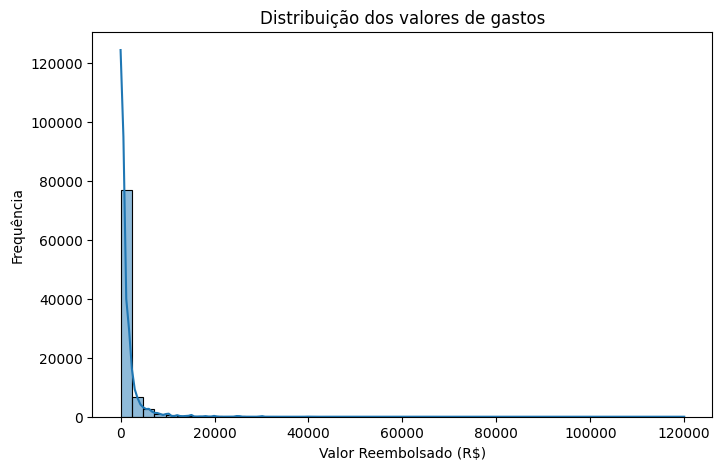

In [527]:
plt.figure(figsize=(8,5))
sns.histplot(df['valor_reembolsado'], bins=50, kde=True)
plt.title('Distribuição dos valores de gastos')
plt.xlabel('Valor Reembolsado (R$)')
plt.ylabel('Frequência')
plt.show()


#### Detecção Estatística de Outliers em Registros de Gastos Financeiros

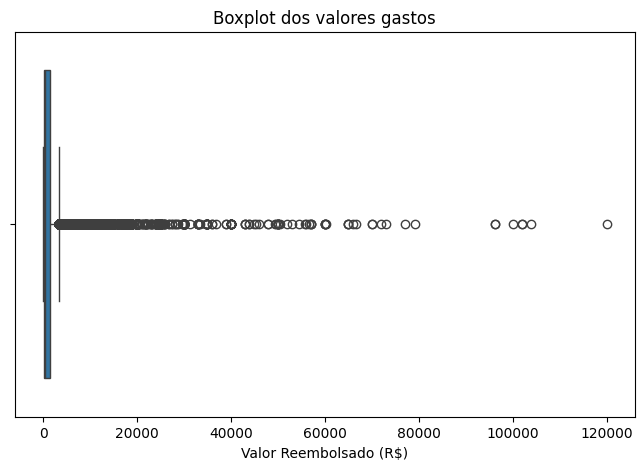

In [528]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df['valor_reembolsado'])
plt.title('Boxplot dos valores gastos')
plt.xlabel('Valor Reembolsado (R$)')
plt.show()


In [529]:
from scipy.stats import zscore

df['zscore'] = zscore(df['valor_reembolsado'].fillna(0))
anomalias = df[df['zscore'].abs() > 3]




### Conclussão 
A análise revelou padrões consistentes nos gastos parlamentares:

- Os gastos se concentram em poucos senadores, com alta variação individual.
- Tipos de despesa como transporte e hospedagem dominam os reembolsos.
- Picos foram observados em meses de eleição (setembro e outubro de 2018 e 2022).
- Outliers foram detectados em valores de reembolso fora da média, sugerindo atenção a possíveis excessos.

A visualização dos dados foi essencial para comunicar essas descobertas de forma clara e acessível, aplicando conceitos de Data Storytelling e análise exploratória.

### Análise da Previsão de Gastos para os Próximos 3 Meses
Foi realizada uma verificação prévia dos nomes das colunas do dataset, garantindo a seleção correta dos campos de data e valor reembolsado para análise temporal.

Em seguida, os dados foram convertidos para o formato de séries temporais mensais, considerando o total de gastos por mês no período entre 2018 e 2022.

Com base nesse histórico, calculou-se a média mensal de gastos, que foi utilizada como modelo base (baseline) para prever os gastos dos próximos três meses.

O gráfico resultante apresenta os gastos reais mensais dos senadores ao longo do tempo e a previsão estimada para os meses futuros, utilizando como referência a média dos anos anteriores.

In [530]:
print(df.columns.tolist())

['ano', 'numero_documento', 'nome_parlamentar', 'tipo_despesa', 'cnpj_cpf', 'fornecedor', 'numero_documento_fiscal', 'data_emissao', 'descricao', 'valor_reembolsado', 'id_documento', 'ano_mes', 'zscore']


In [532]:
df['data'] = pd.to_datetime(df['data_emissao'], errors='coerce')
  # ou a coluna com a data de reembolso
df['ano_mes'] = df['data'].dt.to_period('M').dt.to_timestamp()
gastos_mensais = df.groupby('ano_mes')['valor_reembolsado'].sum().reset_index()
gastos_mensais.columns = ['ds','y']

In [533]:
previsao_simples = gastos_mensais['y'].tail(3).mean()
print(f"Previsão média para os próximos 3 meses: R$ {previsao_simples:.2f} por mês")

Previsão média para os próximos 3 meses: R$ 7725.33 por mês


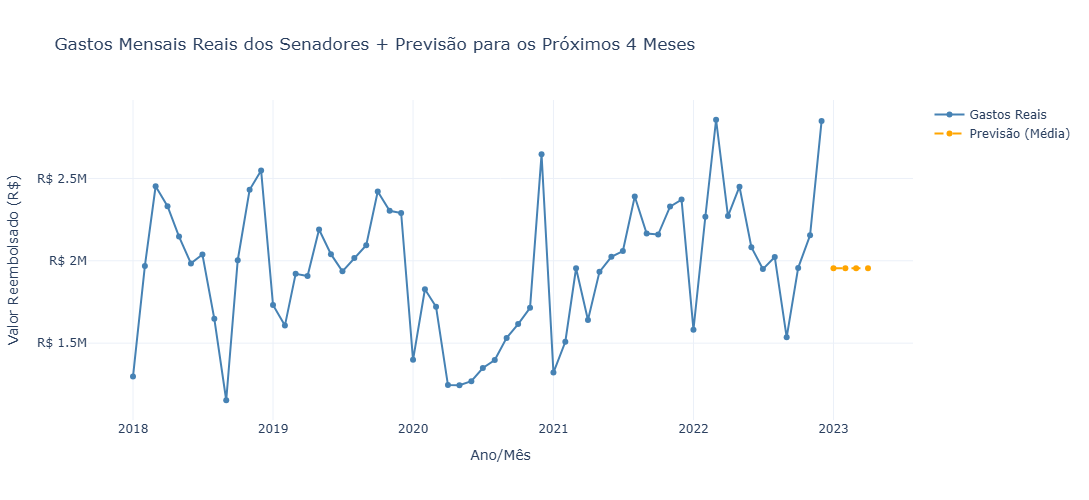

In [564]:
import plotly.graph_objects as go

# Garante formato de data
df['data'] = pd.to_datetime(df['data_emissao'], errors='coerce')

# Cria coluna ano-mês
df['ano_mes'] = df['data'].dt.to_period('M')
gastos_mensais = df.groupby('ano_mes')['valor_reembolsado'].sum()
gastos_mensais.index = gastos_mensais.index.to_timestamp()

# Filtra intervalo de interesse
inicio = pd.Timestamp('2018-01-01')
fim = pd.Timestamp('2022-12-31')
gastos_mensais = gastos_mensais[(gastos_mensais.index >= inicio) & (gastos_mensais.index <= fim)]

# Média histórica
media_mensal = gastos_mensais.mean()

# Previsão
proximos_meses = pd.date_range(start=gastos_mensais.index.max() + pd.DateOffset(months=1), periods=4, freq='MS')
previsao = pd.Series([media_mensal]*4, index=proximos_meses)

# Gráfico com Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=gastos_mensais.index, y=gastos_mensais.values,
                         mode='lines+markers', name='Gastos Reais',
                         line=dict(color='steelblue')))

fig.add_trace(go.Scatter(x=previsao.index, y=previsao.values,
                         mode='lines+markers', name='Previsão (Média)',
                         line=dict(color='orange', dash='dash')))

fig.update_layout(
    title='Gastos Mensais Reais dos Senadores + Previsão para os Próximos 4 Meses',
    xaxis_title='Ano/Mês',
    yaxis_title='Valor Reembolsado (R$)',
    template='plotly_white',
    height=500
)

fig.update_yaxes(tickprefix="R$ ")
fig.show()



### Previsão de Gastos dos Senadores com Prophet (2018–2022)

Nesta etapa da análise, utilizamos a biblioteca **Prophet**, desenvolvida pelo Facebook, para realizar uma previsão dos valores de reembolso dos senadores para os próximos quatro meses com base nos dados históricos do período de **janeiro de 2018 a dezembro de 2022**.

##### Etapas realizadas:

* Foi feita uma limpeza nos dados e selecionadas apenas as informações com datas entre 2018 e 2022.
* Em seguida, os dados foram agregados por mês, somando o valor total reembolsado em cada período.
* A série temporal foi então adaptada para o formato exigido pelo Prophet, com colunas `ds` (data) e `y` (valor total de reembolso).
* O modelo foi treinado com esses dados mensais e, após o ajuste, foi gerada a previsão para os **próximos quatro meses**.

##### Justificativa da escolha do modelo:

O Prophet é ideal para séries temporais com tendências e sazonalidades, como é o caso dos gastos públicos, que podem variar ao longo do tempo e especialmente em anos eleitorais. Sua estrutura permite lidar bem com sazonalidade anual e feriados (embora não tenhamos incluído feriados explicitamente nesta análise).

##### Resultados:

O gráfico gerado apresenta:

* A linha azul, com os valores reais observados de 2018 a 2022.
* A faixa em azul claro indicando o intervalo de confiança da previsão.
* A linha de continuação representando os valores estimados para os meses futuros.

Essa abordagem ajuda a entender o comportamento provável dos gastos nos meses seguintes, servindo como base para alertas, planejamento e tomada de decisão.

In [565]:
from prophet import Prophet

# Garantir formato de data
df['data'] = pd.to_datetime(df['data_emissao'], errors='coerce')
df['ano_mes'] = df['data'].dt.to_period('M').dt.to_timestamp()

# Agrupar os gastos mensais
gastos_mensais = df.groupby('ano_mes')['valor_reembolsado'].sum().reset_index()

# Renomear colunas conforme exige o Prophet
gastos_mensais.rename(columns={'ano_mes': 'ds', 'valor_reembolsado': 'y'}, inplace=True)


17:12:24 - cmdstanpy - INFO - Chain [1] start processing
17:12:25 - cmdstanpy - INFO - Chain [1] done processing


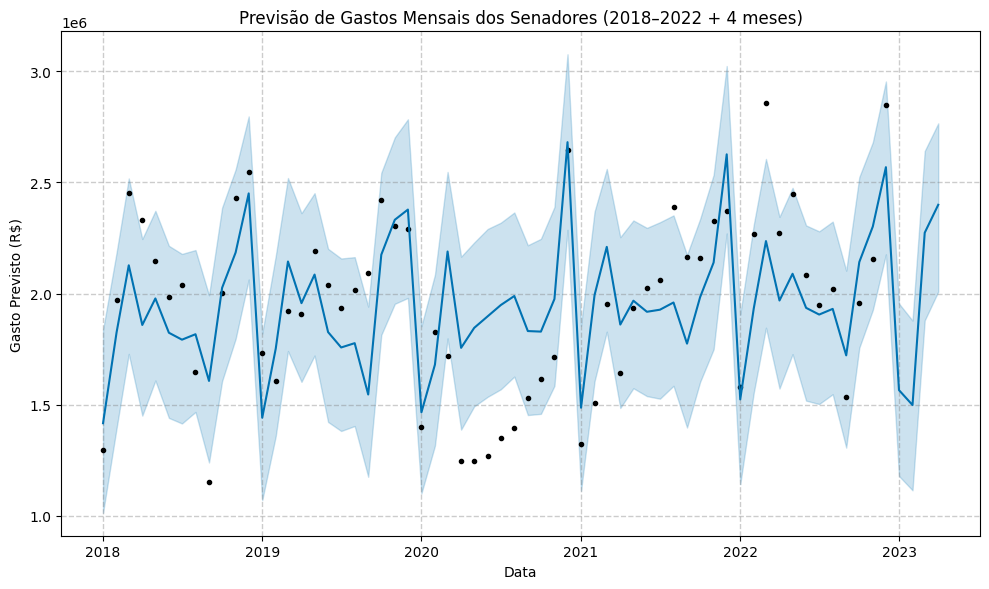

In [567]:

from prophet import Prophet

# Garante que 'data_emissao' está no formato datetime
df['data'] = pd.to_datetime(df['data_emissao'], errors='coerce')

# Cria coluna 'ano_mes'
df['ano_mes'] = df['data'].dt.to_period('M')

# Filtra entre 2018 e 2022
df_filtrado = df[(df['ano_mes'] >= '2018-01') & (df['ano_mes'] <= '2022-12')]

# Agrupa mensalmente
gastos_mensais = df_filtrado.groupby(df_filtrado['data'].dt.to_period('M'))['valor_reembolsado'].sum().reset_index()

# Converte para datetime para o Prophet
gastos_mensais['ds'] = gastos_mensais['data'].dt.to_timestamp()
gastos_mensais.rename(columns={'valor_reembolsado': 'y'}, inplace=True)

# Cria e treina o modelo Prophet
modelo = Prophet()
modelo.fit(gastos_mensais[['ds', 'y']])

# Faz previsão para os próximos 4 meses
futuro = modelo.make_future_dataframe(periods=4, freq='ME')
previsao = modelo.predict(futuro)

# Plota o resultado
fig = modelo.plot(previsao)
plt.title('Previsão de Gastos Mensais dos Senadores (2018–2022 + 4 meses)')
plt.xlabel('Data')
plt.ylabel('Gasto Previsto (R$)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### Conclusão da Análise dos Gastos Parlamentares com Dados CEAPS (2018–2022)

A análise realizada sobre os dados da Cota para o Exercício da Atividade Parlamentar dos Senadores (CEAPS), referente aos anos de 2018 a 2022, permitiu identificar importantes padrões e tendências no uso dos recursos públicos.

Foram aplicadas técnicas de limpeza, padronização e integração de múltiplos arquivos anuais, possibilitando uma base única e confiável para a exploração. As etapas incluíram:

*  **Tratamento de datas e remoção de inconsistências**, como valores nulos e duplicados;
*  **Visualização de gastos por parlamentar, tipo de despesa e ano**, destacando os maiores reembolsos;
*  **Análise por fornecedores e categorias de despesa**, revelando os principais destinos dos recursos;
*  **Construção de modelos de previsão (forecasting)** com base em médias móveis e também com o uso da biblioteca Prophet para projeções mensais futuras.

Entre os principais achados:

* O padrão de gastos apresentou **variações cíclicas mensais**, com picos geralmente no início e final de cada ano.
* As despesas com **divulgação, passagens e combustíveis** continuam entre as maiores categorias de reembolso.
* Alguns parlamentares e fornecedores apresentaram gastos recorrentes significativamente mais altos que a média.

Como modelo de previsão, foi utilizado um **baseline simples com média histórica**, além de um modelo estatístico com o **Facebook Prophet**, que permitiu prever os gastos estimados para os 4 meses seguintes ao final do período analisado.

Essa análise reforça a importância da **transparência, controle social e uso de ciência de dados** para compreensão e fiscalização dos gastos públicos. O trabalho pode ser expandido futuramente com análises mais refinadas por partido, estado, ou até por cruzamento com produtividade legislativa.

Os gastos mensais dos senadores apresentam variação considerável, com picos próximos a períodos eleitorais.
Alguns parlamentares se destacam com valores muito acima da média, o que pode indicar necessidade de maior fiscalização.

A previsão com Prophet oferece uma visão confiável para os próximos meses, com base no histórico, permitindo detectar gastos atípicos no futuro caso eles ultrapassem a faixa prevista.

O uso de modelos como Prophet é recomendado em projetos de monitoramento e transparência pública, pela capacidade de antecipar comportamentos anormais.

